In [97]:
%matplotlib inline

import time

import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# ML methods
from sklearn.svm import LinearSVC # C=1.0
from sklearn.svm import SVC # C=1.0, kernel=’rbf’, gamma=’auto’
from sklearn.linear_model import LogisticRegression # C=1.0, penalty=’l2’ 
from sklearn.ensemble import RandomForestClassifier # n_estimators=10, max_depth=None, max_features=’auto’, criterion='gini'


# Raw data

In [4]:
raw = pandas.read_csv('./KB_data.csv')
raw[:2]

,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_range,opponent,shot_id
0,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),8-16 ft.,POR,2
1,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),16-24 ft.,POR,3


# Cleaning & Enriching


## Raw features

* shot_distance
* loc_x/y: Where on the court. Strong correlation with shot_distance,
* shot_zone_range: Redundant, categorical version of shot_distance
* shot_type: Seems only field goals are included, no penalty shots? Redundant, information is in shot_distance
* shot_zone_area: Rendant, informatino is in loc_x/loc_y
* opponent: Categorical. Approx 20 values
* combined_shot_type: Some correlation with shot_distance. Eg: Dunk always very close, Jump shots mostly far away
* minutes/seconds_remaining: In the period 
* period: Categorical
* season: Related to time (of career). 
* playoffs: 1/0. Different kind of game

## Constructed

Possible

* Nonlinear shot_distance
* time_played = (period * 15 * 60) + (minutes_remaining * 60) + (seconds_remaining) # note: Estimate, since player might not actually play all the time



In [122]:
preprocessed = raw.copy()

# MAYBE: Remove rare super longshots. But only for training, exists in compete set
# raw = raw[raw['shot_distance'] < 30.0]

# Tools

In [101]:
# Poor-mans GridSearchCV
def grid_search(estimator, grid, X, Y, splits=100, test_size=0.3):
    pp = ParameterGrid(grid)
    
    results = []
    
    # Calculate the best hyperparameters
    for model_idx, parameters in enumerate(pp):

        training_accuracies = []
        testing_accuracies = []
        for seed in range(0, splits):
            start_time = time.time()
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
            
            model = estimator(**parameters)
            model.fit(X_train, Y_train)
            
            Y_train_pred = model.predict(X_train)
            Y_test_pred = model.predict(X_test)
            
            train_score = sklearn.metrics.accuracy_score(Y_train, Y_train_pred) 
            test_score = sklearn.metrics.accuracy_score(Y_test, Y_test_pred)
            
            training_accuracies.append(train_score)
            testing_accuracies.append(test_score)
            end_time = time.time()
            print('iteration %d: %.2f seconds' % (seed, end_time-start_time))
            
        result = {
            'training_accuracy': numpy.average(training_accuracies),
            'testing_accuracy': numpy.average(testing_accuracies),
            'parameters': parameters,
        }
        results.append(result)

    # Select best result and retrain model on whole dataset
    by_accuracy = sorted(results, key=lambda r: r['testing_accuracy'])
    best_parameters = by_accuracy[0]['parameters']
    model = estimator(**best_parameters)
    model.fit(X, Y)
            
    return model, results 

## Model

In [158]:
def scale_series(series):
    d = series.values.astype(float).reshape(1, -1)
    return StandardScaler().fit_transform(d)[0,:]

class FeatureEncoder():

    def __init__(self):
        pass
        
    def transform(self, data):
        period_mins = 15
        period_time = (data['minutes_remaining'] * 60) + (data['seconds_remaining'])
        game_time = (data['period']*period_mins*60)
        
        shot_distance_squared = data['shot_distance'] * data['shot_distance']
        # could calculate angle from loc_x/y
        
        features = pandas.DataFrame({
            'shot_type': data['combined_shot_type'].astype('category'),
            'season': data['season'].astype('category'),
            'opponent': data['opponent'].astype('category'),
            'playoffs': data['playoffs'].astype('category'),

            'game_time': scale_series(game_time),
            'period_time': scale_series(period_time),
            'period': data['period'].astype('category'),
            
            'loc_x': scale_series(data['loc_x']), 
            'shot_distance': scale_series(data['shot_distance']),            
            'shot_distance_squared': scale_series(shot_distance_squared),
        })

        categorical = set(['shot_type', 'period', 'season', 'opponent'])
        #selected = 
        
        d = pandas.get_dummies(features, columns=list(categorical), drop_first=True)
        return d
    

encoder = FeatureEncoder()
usage_set = preprocessed[preprocessed['shot_made_flag'].notnull()]

encoded = encoder.transform(usage_set)
X = encoded
Y = usage_set['shot_made_flag'].astype(numpy.bool)
    
def get_model(**params):
    params['dual'] = False # 10x faster
    return LinearSVC(**params)
    
best_model, r = grid_search(get_model, { 'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] }, X, Y, splits=3)
encoded[:1]

iteration 0: 0.42 seconds
iteration 1: 0.43 seconds
iteration 2: 0.38 seconds
iteration 0: 0.44 seconds
iteration 1: 0.43 seconds
iteration 2: 0.42 seconds
iteration 0: 0.48 seconds
iteration 1: 0.48 seconds
iteration 2: 0.46 seconds
iteration 0: 0.53 seconds
iteration 1: 0.52 seconds
iteration 2: 0.47 seconds
iteration 0: 0.54 seconds
iteration 1: 0.53 seconds
iteration 2: 0.46 seconds
iteration 0: 0.54 seconds
iteration 1: 0.54 seconds
iteration 2: 0.55 seconds


,game_time,loc_x,period_time,playoffs,shot_distance,shot_distance_squared,season_1997-98,season_1998-99,season_1999-00,season_2000-01,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
0,0.0,0.0,0.0,0,0.0,0.0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


        0_params  1_training  2_testing
0    {'C': 0.01}    0.613101   0.615566
1     {'C': 0.1}    0.613838   0.615298
2     {'C': 1.0}    0.614022   0.615030
3    {'C': 10.0}    0.614022   0.614922
4   {'C': 100.0}    0.614022   0.614922
5  {'C': 1000.0}    0.614022   0.614922


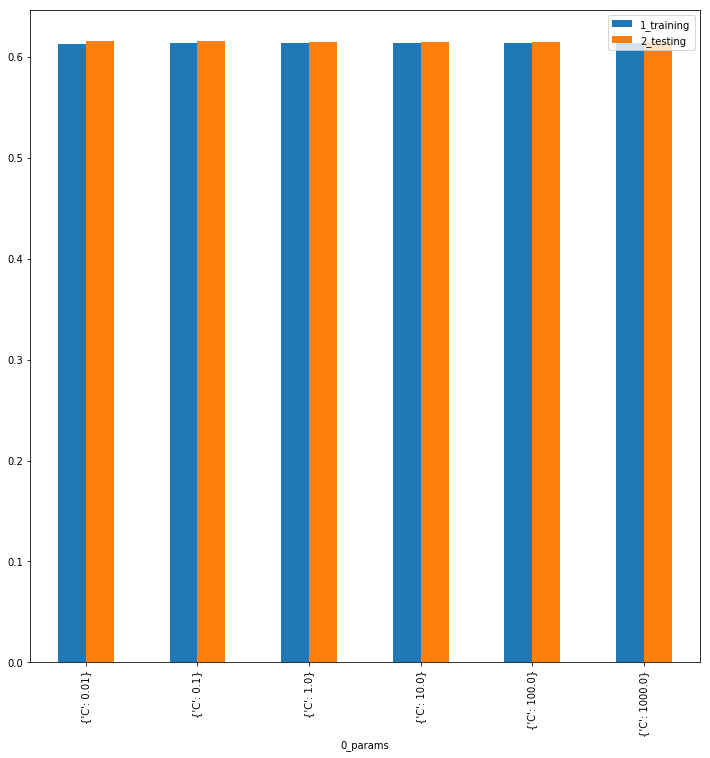

In [159]:
def plot_results(res):
    training = map(lambda r: r['training_accuracy'], res)
    testing = map(lambda r: r['testing_accuracy'], res)
    params = map(lambda r: repr(r['parameters']), res)
    
    df = pandas.DataFrame({
        '0_params': list(params),
        '1_training': list(training),
        '2_testing': list(testing),
    })
    
    print(df)
    
    return df.plot(x='0_params', kind='bar', figsize=(12,12))

plot_results(r)

In [160]:
def make_submission(model, data):    
    assert compete_set['shot_id'].shape[0] == 5000, compete_set.shape
    assert compete_set['shot_id'].values[0] == 4
    assert compete_set['shot_id'].values[-1] == 30693
    
    Y_comp = model.predict(data)
    
    out = compete_set.copy()
    out['shot_made_flag'] = Y_comp.astype(numpy.float)
    out.to_csv('./submission.csv', index=False, columns=['shot_id', 'shot_made_flag'])

compete_set = preprocessed[pandas.isna(preprocessed['shot_made_flag'])]
make_submission(best_model, encoder.transform(compete_set))

# Data exploration

TRY? a dimenson reduction technique to get a feel for the data. PCA/PSLR ?


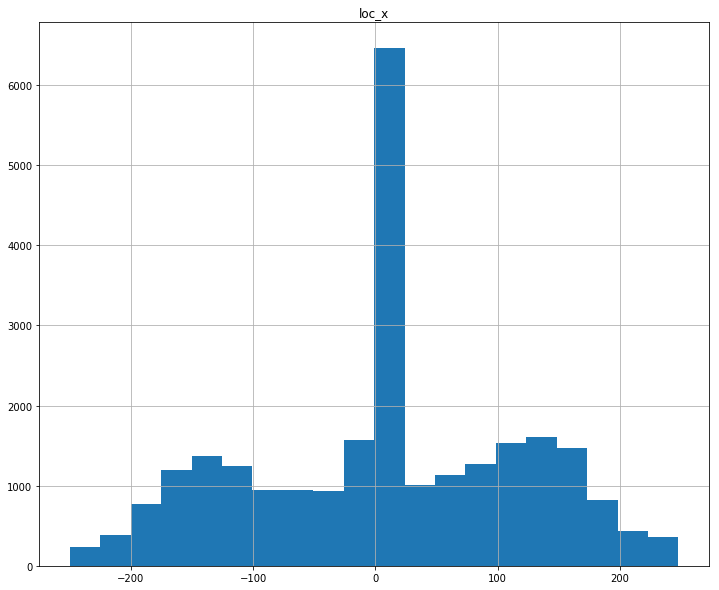

In [155]:
preprocessed.hist(column='loc_x', bins=20, figsize=(12,10), sharey=True);

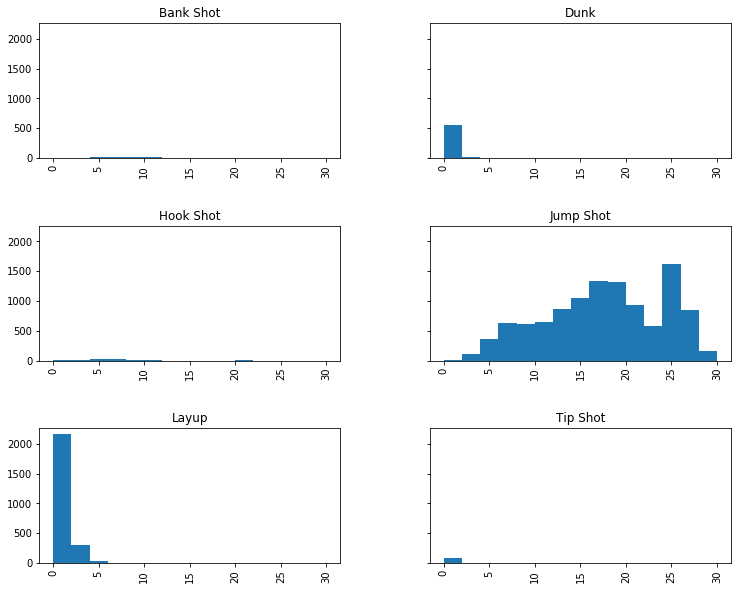

In [167]:
training.hist(column='shot_distance', by='combined_shot_type',
              bins=15, range=(0.0, 30.0), figsize=(12,10), sharey=True
);

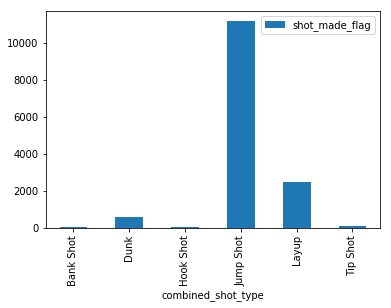

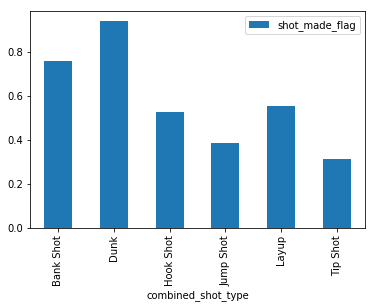

In [169]:
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'count'}).plot(kind='bar')
training.groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

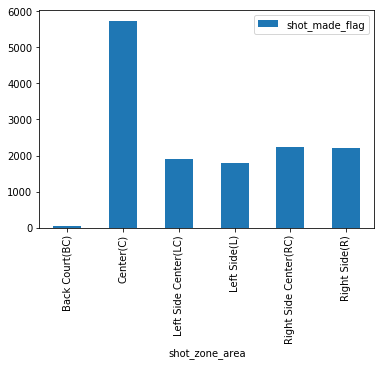

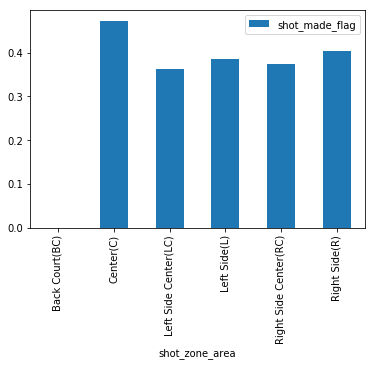

In [173]:
shot_zone = training[training['combined_shot_type'] != 'Dunk'].groupby(['shot_zone_area'])
shot_zone.agg({'shot_made_flag': 'count'}).plot(kind='bar')
shot_zone.agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [150]:
shot_area_type = training.groupby(['shot_zone_area', 'combined_shot_type'])
shot_area_type.agg({'shot_made_flag': 'mean'}).sort_values(by='shot_made_flag', ascending=False).plot(kind='bar')

NameError: name 'training' is not defined

In [174]:
training['season'].unique()

array(['2004-05', '1997-98', '2006-07', '2012-13', '2003-04', '2005-06',
       '2000-01', '2009-10', '2002-03', '2007-08', '2015-16', '2010-11',
       '1998-99', '2001-02', '1999-00', '2013-14', '2008-09', '2011-12',
       '1996-97', '2014-15'], dtype=object)

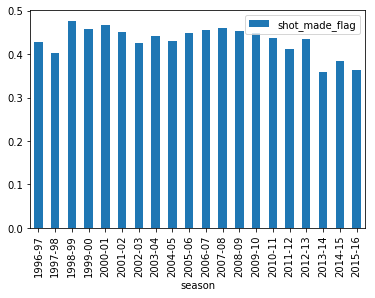

In [175]:
training.groupby(['season']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [11]:
training['opponent'].unique()

array(['DET', 'DAL', 'HOU', 'LAC', 'SAC', 'CHA', 'GSW', 'UTA', 'MIL',
       'IND', 'POR', 'NYK', 'NOH', 'VAN', 'NOP', 'MEM', 'OKC', 'MIN',
       'ORL', 'NJN', 'DEN', 'CLE', 'MIA', 'SEA', 'CHI', 'SAS', 'BOS',
       'PHX', 'WAS', 'TOR', 'PHI', 'ATL', 'BKN'], dtype=object)

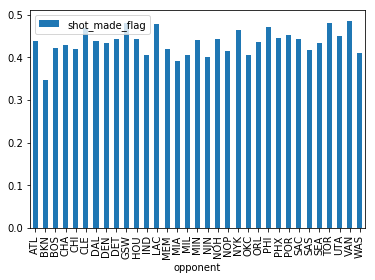

In [30]:
training.groupby(['opponent']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

In [ ]:
# BKN is an outlier, very few matches

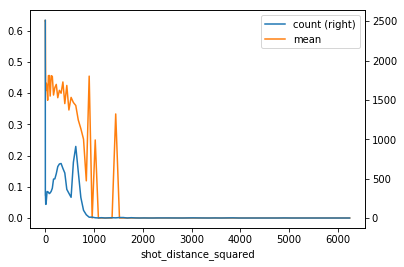

In [202]:
type_by_distance = training[training['combined_shot_type'] != '2Jump Shot'].groupby(['shot_distance_squared'])
count = type_by_distance.agg({'shot_made_flag': 'count'})
mean = type_by_distance.agg({'shot_made_flag': 'mean'})
df = pandas.DataFrame({'count': count['shot_made_flag'], 'mean': mean['shot_made_flag']}, index=count.index)
df.plot(secondary_y='count')

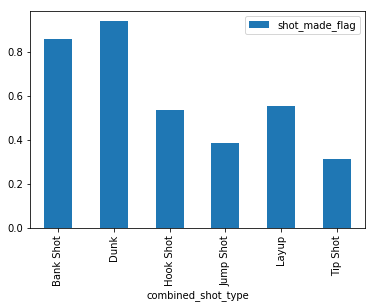

In [95]:
training[training['shot_distance'] < 5.0].groupby(['combined_shot_type']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')

d [ 0.  2.  7. 12. 15. 17. 19. 23. 25. 79.]
e 0 2.0
e 10 2.0
e 10 7.0
e 10 12.0
e 26 2.0
e 26 7.0
e 26 12.0
e 26 15.0
e 26 17.0
e 26 19.0
e 26 23.0
e 26 25.0
e 26 79.0
e 26 2.0
e 26 7.0
e 26 12.0
e 26 15.0
e 26 17.0
e 26 19.0
e 26 23.0
e 26 25.0
e 26 79.0
e 0 2.0
e 0 2.0
e 25 2.0
e 25 7.0
e 25 12.0
e 25 15.0
e 25 17.0
e 25 19.0
e 25 23.0
e 25 25.0
e 25 79.0
e 3 2.0
e 3 7.0
e 17 2.0
e 17 7.0
e 17 12.0
e 17 15.0
e 17 17.0
e 17 19.0
e 0 2.0


,shot_distance,distance_class
5862,0,0
20287,10,2
9367,26,8
16878,26,8
4486,0,0
9591,0,0
7325,25,8
9019,3,1
688,17,5
13191,0,0


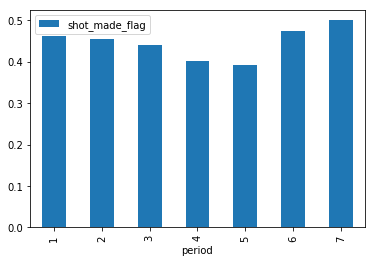

In [251]:
training.groupby(['period']).agg({'shot_made_flag': 'mean'}).plot(kind='bar')